## **A Multi-Dimensional Approach to Player NBA Performance: Integrating Biometrics, Biographies, and Box Score Statistics**

# **Reason for choosing this dataset:**

Integrating biometrics—such as height and weight—with personal biographical data like age and years of experience, alongside in-depth box score statistics—including points scored, rebounds, assists, steals, blocks, and turnovers—creates a rich, multi-dimensional portrait of player performance and potential. This holistic approach not only facilitates diverse analyses, enabling predictions regarding player success, but also helps to uncover the intricate relationships between physical characteristics and various playing styles. Furthermore, it sheds light on the reasons behind the exceptional skills exhibited by players from different nationalities, illustrating the global nature of the sport and the unique contributions from diverse backgrounds.

---


# Importing Libraries

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import ttest_ind

# 1) Data Preprocessing
## Importing our data

In [26]:
nba_players = pd.read_csv('all_seasons.csv')
team_stats = pd.read_csv('nba_team_stats_00_to_23.csv')
team_pg_stats = pd.read_csv('nba_team_stats_playoffs_00_to_21.csv')

## Parsing and Cleaning Data

#### **Convert metrics**

In [27]:
# covert height from cm to ft
nba_players['player_height_ft'] = round(nba_players['player_height'] / 2.54 / 12, 2)
# covert weight from kg to lb
nba_players['player_weight_lb'] = round(nba_players['player_weight'] * 2.204622622, 0)
# convert weight to int
nba_players['player_weight_lb'] = nba_players['player_weight_lb'].astype(int)

#### **Check for missing values**

In [28]:
# Check for missing values
print("\nMissing Values in NBA Players Data:")
print(nba_players.isnull().sum())
print("\nMissing Values in NBA Team Stats Data:")
print(team_stats.isnull().sum())
print("\nMissing Values in NBA Team Playoff Stats Data:")
print(team_pg_stats.isnull().sum())


Missing Values in NBA Players Data:
Unnamed: 0              0
player_name             0
team_abbreviation       0
age                     0
player_height           0
player_weight           0
college              1854
country                 0
draft_year              0
draft_round             0
draft_number            0
gp                      0
pts                     0
reb                     0
ast                     0
net_rating              0
oreb_pct                0
dreb_pct                0
usg_pct                 0
ts_pct                  0
ast_pct                 0
season                  0
player_height_ft        0
player_weight_lb        0
dtype: int64

Missing Values in NBA Team Stats Data:
teamstatspk                 0
Team                        0
games_played                0
wins                        0
losses                      0
win_percentage              0
Min                         0
points                      0
field_goals_made            0
field_goals_atte

Only the college column has missing values. This is because pandas intepreted most as NaN instead of 'None'. We will replace these missing values with 'No College'. However, we will first do a hot deck imputation to see if we can fill in the missing values with the same player's college in a different season (some have None in some season and not in other season e.g "Jay Scrubb").

There are 5 rows with no college mentioned only (empty space). But this can easily be fixed by hot deck imputation where we replace with values found in different seasons (same player).


#### **Correcting features**

In [29]:
# convert age from float to int
nba_players['age'] = nba_players['age'].astype(int)

# We'll convert draft_year from a str to a year by replacing undrafted w/ NaT
nba_players.loc[nba_players['draft_year'] == 'Undrafted', 'draft_year'] = pd.NaT
nba_players['draft_year'] = nba_players['draft_year'].apply(lambda x: pd.to_datetime(x, format='%Y'))

# We'll convert draft_round and draft_number from a str to a int by replacing undrafted w/ 0
nba_players['draft_round'] = nba_players['draft_round'].replace('Undrafted', 0)
nba_players['draft_round'] = nba_players['draft_round'].astype(int)
nba_players['draft_number'] = nba_players['draft_number'].replace('Undrafted', 0)
nba_players['draft_number'] = nba_players['draft_number'].astype(int)

# Column 'Unamed: 0' can be dropped as it is just an index and other redundant columns
nba_players = nba_players.drop(columns=['Unnamed: 0'])
team_stats = team_stats.drop(['teamstatspk'], axis=1)
team_pg_stats = team_pg_stats.drop(['teamstatspk'], axis=1)


#### **Dealing with missing values**

In [30]:
# example before fixing missing values
print("\nExample of Missing College:")
nba_players[nba_players['player_name'] == 'Jay Scrubb']


Example of Missing College:


,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,player_height_ft,player_weight_lb
11234,Jay Scrubb,LAC,20,195.58,99.79024,,USA,2020-01-01,2,55,...,0.3,-2.8,0.022,0.14,0.217,0.458,0.015,2020-21,6.42,220
11834,Jay Scrubb,LAC,21,195.58,99.79024,NaN,USA,2020-01-01,2,55,...,0.4,6.9,0.016,0.10,0.188,0.486,0.095,2021-22,6.42,220
12798,Jay Scrubb,ORL,22,195.58,99.79024,John A. Logan,USA,2020-01-01,2,55,...,0.5,-28.5,0.000,0.30,0.151,0.825,0.056,2022-23,6.42,220


In [31]:


players_with_na_college = nba_players[nba_players['college'].isna()]

# EXPENSIVE OPERATION WARNING!
for index, row in players_with_na_college.iterrows():
  player_name = row['player_name']
  college = row['college']

  # if college is valid skip
  if college == college:
    continue

  # Find other occurrences of the same player where 'college' is valid
  valid_college = nba_players.loc[
      (nba_players['player_name'] == player_name) & 
      (nba_players['college'].notna()) & 
      (nba_players['college'].str.strip() != ''),
      'college'
  ]
  
  # If a valid college is found, update all occurrences of the player with the valid college
  if not valid_college.empty:
      nba_players.loc[nba_players['player_name'] == player_name, 'college'] = valid_college.iloc[0]

# now we replace remaining missing values with 'No College'
nba_players['college'] = nba_players['college'].fillna('No College')

print("\nExample After Fixing Missing College:")
nba_players[nba_players['player_name'] == 'Jay Scrubb']



Example After Fixing Missing College:


,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,player_height_ft,player_weight_lb
11234,Jay Scrubb,LAC,20,195.58,99.79024,John A. Logan,USA,2020-01-01,2,55,...,0.3,-2.8,0.022,0.14,0.217,0.458,0.015,2020-21,6.42,220
11834,Jay Scrubb,LAC,21,195.58,99.79024,John A. Logan,USA,2020-01-01,2,55,...,0.4,6.9,0.016,0.10,0.188,0.486,0.095,2021-22,6.42,220
12798,Jay Scrubb,ORL,22,195.58,99.79024,John A. Logan,USA,2020-01-01,2,55,...,0.5,-28.5,0.000,0.30,0.151,0.825,0.056,2022-23,6.42,220


#### **Check for duplicates**

In [32]:
# check for duplicates
print("\nNumber of Duplicates in NBA Players Data:")
print(nba_players.duplicated().sum())
print("\nNumber of Duplicates in NBA Team Stats Data:")
print(team_stats.duplicated().sum())
print("\nNumber of Duplicates in NBA Team Playoff Stats Data:")
print(team_pg_stats.duplicated().sum())

# More in-depth (looking at set of columns that should be a primary key)
print("nba_players duplicates: " + str(len(nba_players[['player_name', 'team_abbreviation', 'season']].drop_duplicates()) != len(nba_players)))
print("team_stats duplicates: " + str(len(team_stats[['Team', 'season']].drop_duplicates()) != len(team_stats)))
print("team_pg_stats duplicates: " + str(len(team_pg_stats[['team', 'season']].drop_duplicates()) != len(team_pg_stats)))

# now our player data is clean
print(nba_players.isnull().sum())


Number of Duplicates in NBA Players Data:
0

Number of Duplicates in NBA Team Stats Data:
0

Number of Duplicates in NBA Team Playoff Stats Data:
0
nba_players duplicates: False
team_stats duplicates: False
team_pg_stats duplicates: False
player_name             0
team_abbreviation       0
age                     0
player_height           0
player_weight           0
college                 0
country                 0
draft_year           2358
draft_round             0
draft_number            0
gp                      0
pts                     0
reb                     0
ast                     0
net_rating              0
oreb_pct                0
dreb_pct                0
usg_pct                 0
ts_pct                  0
ast_pct                 0
season                  0
player_height_ft        0
player_weight_lb        0
dtype: int64


Ignore draft_year null values - we converted "Undrafted" to NaT

In [33]:
nba_players.head()

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,player_height_ft,player_weight_lb
0,Randy Livingston,HOU,22,193.04,94.800728,Louisiana State,USA,1996-01-01,2,42,...,2.4,0.3,0.042,0.071,0.169,0.487,0.248,1996-97,6.33,209
1,Gaylon Nickerson,WAS,28,190.50,86.182480,Northwestern Oklahoma,USA,1994-01-01,2,34,...,0.3,8.9,0.030,0.111,0.174,0.497,0.043,1996-97,6.25,190
2,George Lynch,VAN,26,203.20,103.418976,North Carolina,USA,1993-01-01,1,12,...,1.9,-8.2,0.106,0.185,0.175,0.512,0.125,1996-97,6.67,228
3,George McCloud,LAL,30,203.20,102.058200,Florida State,USA,1989-01-01,1,7,...,1.7,-2.7,0.027,0.111,0.206,0.527,0.125,1996-97,6.67,225
4,George Zidek,DEN,23,213.36,119.748288,UCLA,USA,1995-01-01,1,22,...,0.3,-14.1,0.102,0.169,0.195,0.500,0.064,1996-97,7.00,264


### Organizing Data

#### **Merge Player Data with Team Stats**

In [34]:
# Merge datasets on 'season' column
nba_combined = pd.merge(nba_players, team_stats, how='left', on='season', suffixes=('_player', '_team'))

print("\nCombined Data:")
print(nba_combined.head())


Combined Data:
        player_name team_abbreviation  age  player_height  player_weight  \
0  Randy Livingston               HOU   22         193.04      94.800728   
1  Gaylon Nickerson               WAS   28         190.50      86.182480   
2      George Lynch               VAN   26         203.20     103.418976   
3    George McCloud               LAL   30         203.20     102.058200   
4      George Zidek               DEN   23         213.36     119.748288   

                 college country draft_year  draft_round  draft_number  ...  \
0        Louisiana State     USA 1996-01-01            2            42  ...   
1  Northwestern Oklahoma     USA 1994-01-01            2            34  ...   
2         North Carolina     USA 1993-01-01            1            12  ...   
3          Florida State     USA 1989-01-01            1             7  ...   
4                   UCLA     USA 1995-01-01            1            22  ...   

   defensive_rebounds  rebounds  assists  turnovers 

# 2) Data Exploration

### **Basic Summary**

In [35]:
print("\nNumber of Entries in NBA Players Data:", nba_players.shape[0])
print("Number of Features in NBA Players Data:", nba_players.shape[1])

season_range = nba_players['season'].unique()
print("\nRange of Seasons:", season_range.min(), "to", season_range.max())

unique_players = nba_players['player_name'].nunique()
print("Number of Unique Players:", unique_players)

unique_teams = nba_players['team_abbreviation'].nunique()
print("Number of Teams:", unique_teams)


Number of Entries in NBA Players Data: 12844
Number of Features in NBA Players Data: 23

Range of Seasons: 1996-97 to 2022-23
Number of Unique Players: 2551
Number of Teams: 36


#### **Variance of Columns**

In [36]:
# Calculate variance of numeric columns
numeric_cols = nba_players.select_dtypes(include=['int64', 'float64']).columns
variance = nba_players[numeric_cols].var()

print("\nVariance:")
print(variance)


Variance:
age                  18.828749
player_height        83.011965
player_weight       154.421085
draft_round           0.466794
draft_number        282.350096
gp                  629.252415
pts                  36.199156
reb                   6.139912
ast                   3.243024
net_rating          160.405369
oreb_pct              0.001878
dreb_pct              0.003908
usg_pct               0.002867
ts_pct                0.010348
ast_pct               0.008868
player_height_ft      0.089407
player_weight_lb    750.526734
dtype: float64


### Examining nba_players (NBA Players Stats (1996-2022))

In [37]:
print("Columns: ")
print(nba_players.columns, "\n\n")

print("Column Types:")
print(nba_players.dtypes, "\n\n")

for column in nba_players.columns:
  print(nba_players[column].describe())
# Somethings to note:
# player_height is in cm, player_weight is in kg
# pts, reb, ast are averaged

# Somethings to note about the data:
# 'draft_year', 'draft_round', and 'draft_number' are type string b/c of value 'undrafted', can substitute undraft w/ missing placeholder (such as -1 for ints, 0000 for year)
# Column 'Unamed: 0' can be dropped as it is just an index
# age could be converted to type int
nba_players

Columns: 
Index(['player_name', 'team_abbreviation', 'age', 'player_height',
       'player_weight', 'college', 'country', 'draft_year', 'draft_round',
       'draft_number', 'gp', 'pts', 'reb', 'ast', 'net_rating', 'oreb_pct',
       'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct', 'season',
       'player_height_ft', 'player_weight_lb'],
      dtype='object') 


Column Types:
player_name                  object
team_abbreviation            object
age                           int64
player_height               float64
player_weight               float64
college                      object
country                      object
draft_year           datetime64[ns]
draft_round                   int64
draft_number                  int64
gp                            int64
pts                         float64
reb                         float64
ast                         float64
net_rating                  float64
oreb_pct                    float64
dreb_pct                    float64
usg_pct     

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,player_height_ft,player_weight_lb
0,Randy Livingston,HOU,22,193.04,94.800728,Louisiana State,USA,1996-01-01,2,42,...,2.4,0.3,0.042,0.071,0.169,0.487,0.248,1996-97,6.33,209
1,Gaylon Nickerson,WAS,28,190.50,86.182480,Northwestern Oklahoma,USA,1994-01-01,2,34,...,0.3,8.9,0.030,0.111,0.174,0.497,0.043,1996-97,6.25,190
2,George Lynch,VAN,26,203.20,103.418976,North Carolina,USA,1993-01-01,1,12,...,1.9,-8.2,0.106,0.185,0.175,0.512,0.125,1996-97,6.67,228
3,George McCloud,LAL,30,203.20,102.058200,Florida State,USA,1989-01-01,1,7,...,1.7,-2.7,0.027,0.111,0.206,0.527,0.125,1996-97,6.67,225
4,George Zidek,DEN,23,213.36,119.748288,UCLA,USA,1995-01-01,1,22,...,0.3,-14.1,0.102,0.169,0.195,0.500,0.064,1996-97,7.00,264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12839,Joel Embiid,PHI,29,213.36,127.005760,Kansas,Cameroon,2014-01-01,1,3,...,4.2,8.8,0.057,0.243,0.370,0.655,0.233,2022-23,7.00,280
12840,John Butler Jr.,POR,20,213.36,86.182480,Florida State,USA,NaT,0,0,...,0.6,-16.1,0.012,0.065,0.102,0.411,0.066,2022-23,7.00,190
12841,John Collins,ATL,25,205.74,102.511792,Wake Forest,USA,2017-01-01,1,19,...,1.2,-0.2,0.035,0.180,0.168,0.593,0.052,2022-23,6.75,226
12842,Jericho Sims,NYK,24,208.28,113.398000,Texas,USA,2021-01-01,2,58,...,0.5,-6.7,0.117,0.175,0.074,0.780,0.044,2022-23,6.83,250


### Examining team_stats (Regular Season Stats 2000-2023)

In [38]:
print("Columns: ")
print(team_stats.columns, "\n")

print("Column Types:")
print(team_stats.dtypes)

team_stats

Columns: 
Index(['Team', 'games_played', 'wins', 'losses', 'win_percentage', 'Min',
       'points', 'field_goals_made', 'field_goals_attempted',
       'field_goal_percentage', 'three_pointers_made',
       'three_pointers_attempted', 'three_point_percentage',
       'free_throws_made', 'free_throw_attempted', 'free_throw_percentage',
       'offensive_rebounds', 'defensive_rebounds', 'rebounds', 'assists',
       'turnovers', 'steals', 'blocks', 'blocks_attempted', 'personal_fouls',
       'personal_fouls_drawn', 'plus_minus', 'season'],
      dtype='object') 

Column Types:
Team                         object
games_played                  int64
wins                          int64
losses                        int64
win_percentage              float64
Min                           int64
points                        int64
field_goals_made              int64
field_goals_attempted         int64
field_goal_percentage       float64
three_pointers_made           int64
three_pointers_attem

,Team,games_played,wins,losses,win_percentage,Min,points,field_goals_made,field_goals_attempted,field_goal_percentage,...,rebounds,assists,turnovers,steals,blocks,blocks_attempted,personal_fouls,personal_fouls_drawn,plus_minus,season
0,Boston Celtics,82,64,18,0.780,3966,9887,3601,7396,48.7,...,3799,2207,979,557,538,304,1326,1416,930,2023-24
1,Denver Nuggets,82,57,25,0.695,3941,9418,3610,7279,49.6,...,3643,2415,1036,585,456,394,1489,1467,431,2023-24
2,Oklahoma City Thunder,82,57,25,0.695,3961,9847,3653,7324,49.9,...,3447,2223,1039,694,538,419,1545,1548,608,2023-24
3,Minnesota Timberwolves,82,56,26,0.683,3961,9264,3383,6974,48.5,...,3577,2184,1162,647,497,371,1544,1630,529,2023-24
4,LA Clippers,82,51,31,0.622,3941,9481,3473,7108,48.9,...,3523,2097,1078,640,413,384,1519,1537,269,2023-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,Atlanta Hawks,82,25,57,0.305,3946,7459,2876,6668,43.1,...,3518,1559,1368,634,387,513,1863,7,-427,2000-01
712,Vancouver Grizzlies,82,23,59,0.280,3956,7522,2870,6539,43.9,...,3325,1899,1291,586,359,476,1733,5,-470,2000-01
713,Washington Wizards,82,19,63,0.232,3936,7645,2833,6453,43.9,...,3386,1647,1391,630,383,511,1913,9,-547,2000-01
714,Golden State Warriors,82,17,65,0.207,3956,7584,2937,7175,40.9,...,3730,1788,1301,742,410,493,1727,6,-742,2000-01


### Examining team_pg_stats (Playoff Games Stats 2000-2021)

In [39]:
print("Columns: ")
print(team_pg_stats.columns, "\n")

print("Column Types:")
print(team_pg_stats.dtypes)

team_pg_stats

Columns: 
Index(['team', 'games_played', 'wins', 'losses', 'win_percentage', 'minutes',
       'points', 'field_goals_made', 'field_goals_attempted',
       'field_goal_percentage', 'three_pointers_made',
       'three_pointers_attempted', 'three_point_percentage',
       'free_throws_made', 'free_throw_attempted', 'free_throw_percentage',
       'offensive_rebounds', 'defensive_rebounds', 'rebounds', 'assists',
       'turnovers', 'steals', 'blocks', 'blocks_attempted', 'personal_fouls',
       'personal_fouls_drawn', 'plus_minus', 'season'],
      dtype='object') 

Column Types:
team                         object
games_played                  int64
wins                          int64
losses                        int64
win_percentage              float64
minutes                     float64
points                      float64
field_goals_made            float64
field_goals_attempted       float64
field_goal_percentage       float64
three_pointers_made         float64
three_pointers_a

,team,games_played,wins,losses,win_percentage,minutes,points,field_goals_made,field_goals_attempted,field_goal_percentage,...,rebounds,assists,turnovers,steals,blocks,blocks_attempted,personal_fouls,personal_fouls_drawn,plus_minus,season
0,Milwaukee Bucks,23,16,7,0.696,48.4,110.3,42.1,91.1,46.2,...,49.0,22.8,12.7,7.8,4.2,3.8,18.0,20.1,5.1,2020-21
1,Phoenix Suns,22,14,8,0.636,48.0,109.0,40.9,85.0,48.1,...,42.7,23.2,11.9,6.5,4.2,3.6,19.7,18.5,4.5,2020-21
2,Brooklyn Nets,12,7,5,0.583,48.4,112.5,40.7,86.2,47.2,...,42.6,22.6,11.6,7.1,4.8,6.2,21.2,18.6,6.3,2020-21
3,Philadelphia 76ers,12,7,5,0.583,48.0,116.3,42.5,85.8,49.6,...,44.7,24.9,12.8,8.0,6.2,3.8,23.0,23.8,7.5,2020-21
4,Atlanta Hawks,18,10,8,0.556,48.0,106.3,38.9,86.8,44.9,...,42.4,20.2,12.4,6.7,4.4,4.3,21.2,20.3,-1.5,2020-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,Minnesota Timberwolves,4,1,3,0.250,48.0,82.0,30.8,79.5,38.7,...,42.5,18.5,12.8,7.5,5.8,4.5,24.3,0.0,-6.5,2000-01
332,Orlando Magic,4,1,3,0.250,49.3,102.8,39.0,89.8,43.5,...,43.8,22.0,11.3,8.0,6.3,5.3,26.5,0.3,-5.8,2000-01
333,Phoenix Suns,4,1,3,0.250,48.0,88.5,34.0,89.5,38.0,...,44.3,21.3,13.8,9.8,5.8,5.3,23.5,0.0,-9.5,2000-01
334,Miami Heat,3,0,3,0.000,48.0,78.3,29.7,72.3,41.0,...,35.0,16.7,18.7,5.0,5.0,4.0,25.3,0.3,-22.3,2000-01


#### Distribution of Points per Player:

In [ ]:
# Converting appropriate columns to numeric types (if necessary)
nba_players['draft_year'] = pd.to_numeric(nba_players['draft_year'], errors='coerce')
nba_players['draft_number'] = pd.to_numeric(nba_players['draft_number'], errors='coerce')

# Handling any missing values by filling or dropping (for simplicity, filling with 0s for draft-related columns)
nba_players['draft_year'] = nba_players['draft_year'].fillna(0)
nba_players['draft_number'] = nba_players['draft_number'].fillna(0)

# Checking if there are missing values across all datasets
missing_all_seasons = nba_players.isnull().sum()
missing_team_stats = team_stats.isnull().sum()
missing_playoffs_stats = team_pg_stats.isnull().sum()

# Converting season columns to proper format
team_stats['season'] = team_stats['season'].astype(str)
team_pg_stats['season'] = team_pg_stats['season'].astype(str)

# Extracting statistical summaries
summary_all_seasons = nba_players.describe()
summary_team_stats = team_stats.describe()
summary_playoffs_stats = team_pg_stats.describe()

missing_all_seasons, missing_team_stats, missing_playoffs_stats, summary_all_seasons

(player_name          0
 team_abbreviation    0
 age                  0
 player_height        0
 player_weight        0
 college              0
 country              0
 draft_year           0
 draft_round          0
 draft_number         0
 gp                   0
 pts                  0
 reb                  0
 ast                  0
 net_rating           0
 oreb_pct             0
 dreb_pct             0
 usg_pct              0
 ts_pct               0
 ast_pct              0
 season               0
 player_height_ft     0
 player_weight_lb     0
 height_division      0
 dtype: int64,
 Team                        0
 games_played                0
 wins                        0
 losses                      0
 win_percentage              0
 Min                         0
 points                      0
 field_goals_made            0
 field_goals_attempted       0
 field_goal_percentage       0
 three_pointers_made         0
 three_pointers_attempted    0
 three_point_percentage      0
 free_

Mean Points per Player: 8.2
Maximum Points: 36.1
Most players score between 3.6 to 11.5 points (25th to 75th percentile).


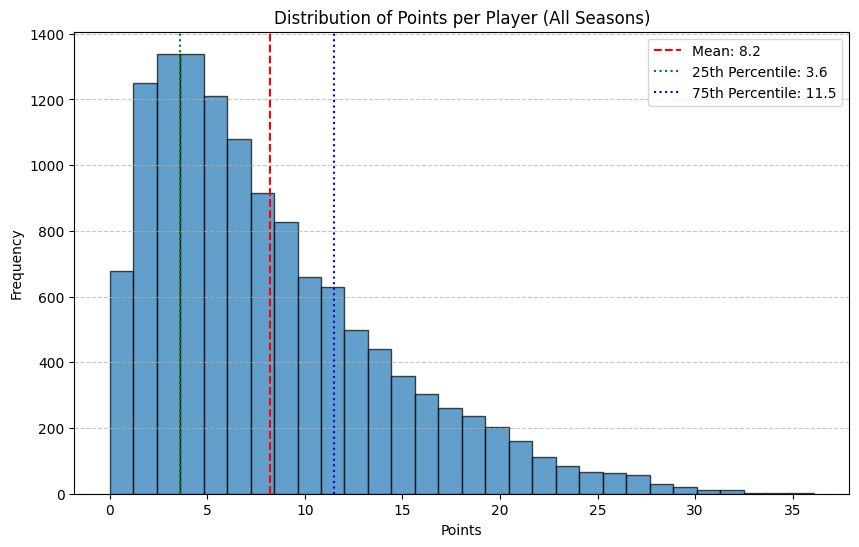

In [41]:
# Calculate statistics
mean_points = nba_players['pts'].mean()
max_points = nba_players['pts'].max()
points_25th = nba_players['pts'].quantile(0.25)
points_75th = nba_players['pts'].quantile(0.75)

# Display statistics
print(f"Mean Points per Player: {mean_points:.1f}")
print(f"Maximum Points: {max_points}")
print(f"Most players score between {points_25th} to {points_75th} points (25th to 75th percentile).")

# Plot: Distribution of Points per Player
plt.figure(figsize=(10, 6))
plt.hist(nba_players['pts'], bins=30, edgecolor='black', alpha=0.7)
plt.axvline(mean_points, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_points:.1f}')
plt.axvline(points_25th, color='green', linestyle='dotted', linewidth=1.5, label=f'25th Percentile: {points_25th}')
plt.axvline(points_75th, color='blue', linestyle='dotted', linewidth=1.5, label=f'75th Percentile: {points_75th}')
plt.title('Distribution of Points per Player (All Seasons)')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Distribution of Rebounds per Player: 

Mean Rebounds per Player: 3.6
Maximum Rebounds: 16.3
Most players grab between 1.8 to 4.7 rebounds (25th to 75th percentile).


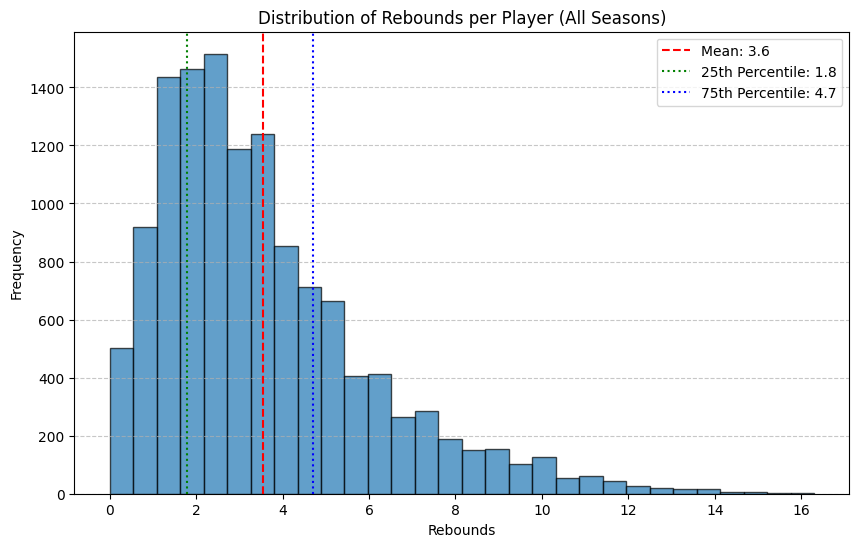

In [42]:
#Calculate statistics for rebounds
mean_rebounds = nba_players['reb'].mean()
max_rebounds = nba_players['reb'].max()
rebounds_25th = nba_players['reb'].quantile(0.25)
rebounds_75th = nba_players['reb'].quantile(0.75)

# Display statistics
print(f"Mean Rebounds per Player: {mean_rebounds:.1f}")
print(f"Maximum Rebounds: {max_rebounds}")
print(f"Most players grab between {rebounds_25th} to {rebounds_75th} rebounds (25th to 75th percentile).")

# Plot: Distribution of Rebounds per Player
plt.figure(figsize=(10, 6))
plt.hist(nba_players['reb'], bins=30, edgecolor='black', alpha=0.7)
plt.axvline(mean_rebounds, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_rebounds:.1f}')
plt.axvline(rebounds_25th, color='green', linestyle='dotted', linewidth=1.5, label=f'25th Percentile: {rebounds_25th}')
plt.axvline(rebounds_75th, color='blue', linestyle='dotted', linewidth=1.5, label=f'75th Percentile: {rebounds_75th}')
plt.title('Distribution of Rebounds per Player (All Seasons)')
plt.xlabel('Rebounds')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Correlation Between Points, Rebounds, And Assists

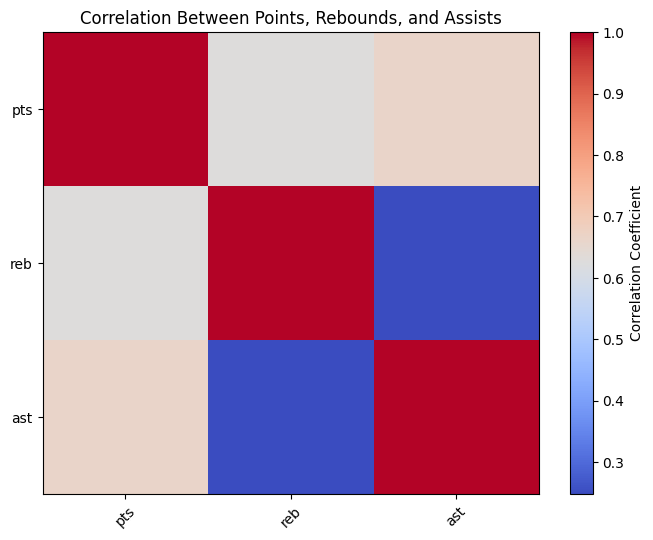

Correlation Matrix:
           pts       reb       ast
pts  1.000000  0.624509  0.664320
reb  0.624509  1.000000  0.247841
ast  0.664320  0.247841  1.000000


(count    12844.000000
 mean         8.212582
 std          6.016573
 min          0.000000
 25%          3.600000
 50%          6.700000
 75%         11.500000
 max         36.100000
 Name: pts, dtype: float64,
 count    12844.000000
 mean         3.558486
 std          2.477885
 min          0.000000
 25%          1.800000
 50%          3.000000
 75%          4.700000
 max         16.300000
 Name: reb, dtype: float64)

In [43]:
# Calculate the correlation matrix for points, rebounds, and assists
correlation_matrix = nba_players[['pts', 'reb', 'ast']].corr()

# Plot: Correlation Heatmap
plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none', aspect='auto')
plt.colorbar(label='Correlation Coefficient')

# Set tick labels for heatmap
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)

# Add title and grid
plt.title('Correlation Between Points, Rebounds, and Assists')
plt.grid(False)  # Avoid clutter with a heatmap grid

# Show the plot
plt.show()

# Display the correlation matrix in the console
print("Correlation Matrix:\n", correlation_matrix)

# Basic statistics on points and rebounds
points_stats = nba_players['pts'].describe()
rebounds_stats = nba_players['reb'].describe()

points_stats, rebounds_stats

**Correlation Analysis**

The correlation heatmap and matrix reveal the following:

* Points and Assists: High positive correlation (0.66) — players who score more tend to also accumulate more assists.
* Points and Rebounds: Moderate positive correlation (0.62) — players scoring high points often contribute to rebounds.
* Rebounds and Assists: Weak positive correlation (0.25) — indicating that these two metrics are not as strongly related.


This analysis suggests that scorers are often playmakers (high assist stats) but there is a lesser relationship between assists and rebounding performance.

---

# 3) Statistical Analysis and Hypothesis Testing

#### **Using an ANOVA test, we want to see: Does a player's height give any advantage towards the amount of points they earn on average?**
* HO : Height does not affect how many points a player score on average

* HA : Height does influence a player's average scoring capability


The players are divided into three groups: small, average, and large. Players
that are less than the 33rd quartile are considered small, those taller than the
66th quartile are considered large, and the remaining are average.

ANOVA Test Results:
F_onewayResult(statistic=np.float64(20.170348854569863), pvalue=np.float64(1.7941545432241532e-09)) 



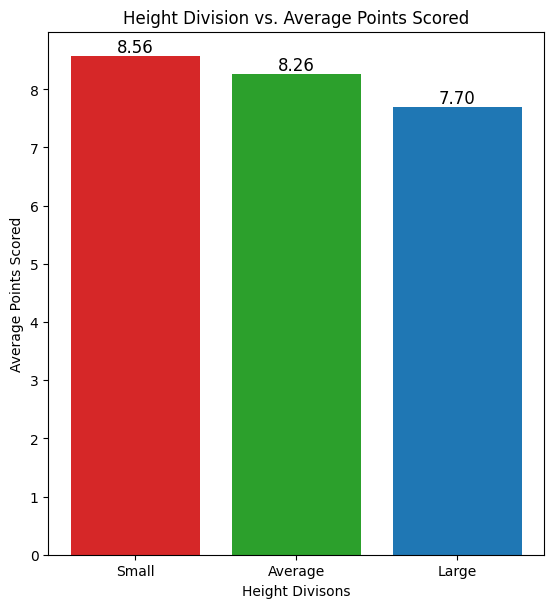


Our ANOVA Test resulted in a p-value of 1.79e-09 which is quite small. Suppose
we decided that our significance level, or alpha, is 0.05. Our p-value is much
lower than alpha, signaling that the chances of our results occurring due to
chance, assuming that the null hypothesis is true, is quite low. Therefore, we'll
conclude that height does have an impact on how many points a player earns on
average. However, we can't conclude between which groups is this difference observed.

Post-Hoc Test Results:
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.301     0.041     0.010     0.592
 (0 - 2)      0.869     0.000     0.546     1.192
 (1 - 0)     -0.301     0.041    -0.592    -0.010
 (1 - 2)      0.567     0.000     0.257     0.878
 (2 - 0)     -0.869     0.000    -1.192    -0.546
 (2 - 1)     -0.567     0.000    -0.878    -0.257

Since we rejected the null hypothesis using the ANOVA Test, we'll explore
t

In [44]:
# Create categorical variable 'height_division' with three subcategories grouped by height
nba_players['height_division'] = pd.qcut(nba_players['player_height'], q=[0, 1/3, 2/3, 1], labels=["small", "average", "large"])

print("""
The players are divided into three groups: small, average, and large. Players
that are less than the 33rd quartile are considered small, those taller than the
66th quartile are considered large, and the remaining are average.
""")

# ANOVA Test
anova_rst = stats.f_oneway(nba_players[nba_players['height_division'] == 'small']['pts'],
               nba_players[nba_players['height_division'] == 'average']['pts'],
               nba_players[nba_players['height_division'] == 'large']['pts'])

print("ANOVA Test Results:")
print(anova_rst, "\n")

small_mean = nba_players[nba_players['height_division'] == 'small']['pts'].mean()
avg_mean = nba_players[nba_players['height_division'] == 'average']['pts'].mean()
large_mean = nba_players[nba_players['height_division'] == 'large']['pts'].mean()

colors=['tab:red', 'tab:green', 'tab:blue']
fig, ax = plt.subplots(1, 1)
bars = ax.bar(['Small', 'Average', 'Large'], [small_mean, avg_mean, large_mean],
       color=colors)
ax.set_title('Height Division vs. Average Points Scored')
ax.set_xlabel('Height Divisons')
ax.set_ylabel('Average Points Scored')
ax.bar_label(bars, fmt='{:,.2f}', fontsize=12)
plt.subplots_adjust(top=1.2)
plt.show()

print("""
Our ANOVA Test resulted in a p-value of 1.79e-09 which is quite small. Suppose
we decided that our significance level, or alpha, is 0.05. Our p-value is much
lower than alpha, signaling that the chances of our results occurring due to
chance, assuming that the null hypothesis is true, is quite low. Therefore, we'll
conclude that height does have an impact on how many points a player earns on
average. However, we can't conclude between which groups is this difference observed.""")

# Post-Hoc Test (Remove if unnecessary)
posthoc_rst = stats.tukey_hsd(nba_players[nba_players['height_division'] == 'small']['pts'],
                      nba_players[nba_players['height_division'] == 'average']['pts'],
                      nba_players[nba_players['height_division'] == 'large']['pts'])

print("\nPost-Hoc Test Results:")
print(posthoc_rst)

print("""Since we rejected the null hypothesis using the ANOVA Test, we'll explore
the direct differences in the mean with each group using a post-hoc test, more
specifically the Tukey Honestly Significant Difference Test. Within this test
each group's mean is directly compared with the other two groups (ex. small vs.
average, small vs. large, etc.) and a p-value is produced for each comparison.
From our observation, we found that all the p-values were lower than our alpha
(same alpha we had during the ANOVA Test) which means we can reject the null
hypothesis in all comparisons. This means that height does play a difference in a
player's average score across our simplified categorization of height.""")

#### **Continuing the pattern of looking at player biometrics, we want to see if the age of players has significant effect on the average amount of points scored. This is associated with their years of experience. We will perform a two-tailed t-test to view this relationship. We will use a p-value of 0.05 for this experiment.**
* HO : Player's age has no effect on average points scored

* HA : Player's age does have an effect on average points scored


To conduct this t-test, the players are divided into two age groups based on the median age. 
Players less than the median age are considered younger players, and players older
than the median age are considered older players. The mean points scored for these
player age groups will be compared using a t-test.



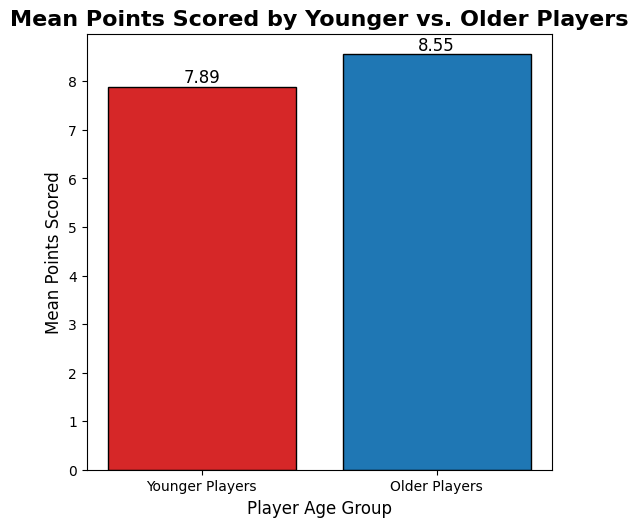

The p-value from the conducted t-test is shown below: 
3.587912704666241e-10
 
We can see that the p-value is 3.58e-10. With a significance level of 0.05, this p-value
indicates we have strong evidence to reject the null hypothesis since it is much lower than
the p-value. Thus, the results suggest that the age of players does have a significant effect 
on the number of points scored.


In [60]:
median_age = nba_players['age'].median()

young_pts = nba_players[nba_players['age'] <= median_age]['pts']
old_pts = nba_players[nba_players['age'] > median_age]['pts']

t_stat, p_value = ttest_ind(young_pts, old_pts)

print("""
To conduct this t-test, the players are divided into two age groups based on the median age. 
Players less than the median age are considered younger players, and players older
than the median age are considered older players. The mean points scored for these
player age groups will be compared using a t-test.
""")

young_mean = young_pts.mean()
old_mean = old_pts.mean()

colors = ['tab:red', 'tab:blue']
fig, ax = plt.subplots(figsize=(6, 4))

bars = plt.bar(['Younger Players', 'Older Players'], [young_mean, old_mean], color=colors, edgecolor='black')

plt.title('Mean Points Scored by Younger vs. Older Players', fontsize=16, weight='bold')
plt.ylabel('Mean Points Scored', fontsize=12)
plt.xlabel('Player Age Group', fontsize=12)

ax.bar_label(bars, fmt='{:,.2f}', fontsize=12)
plt.subplots_adjust(top=1.2)
plt.show()

print("""The p-value from the conducted t-test is shown below: """)
print(float(p_value))

print(""" 
We can see that the p-value is 3.58e-10. With a significance level of 0.05, this p-value
indicates we have strong evidence to reject the null hypothesis since it is much lower than
the p-value. Thus, the results suggest that the age of players does have a significant effect 
on the number of points scored.""")